In [1]:
import pandas as pd
import backtrader as bt
import datetime
import yfinance as yf
import backtrader.analyzers as btanalyzers
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("predicted_vs_actual_eps.csv")
data
eps_data = pd.read_csv("eps_values.csv")
eps_data

,PENDS,OFTIC,EPS
0,2011-06-30,AAPL,0.2782
1,2011-09-30,AAPL,0.2518
2,2011-12-31,AAPL,0.4954
3,2012-03-31,AAPL,0.4393
4,2012-06-30,AAPL,0.3329
...,...,...,...
9655,2018-12-31,ZION,1.0800
9656,2019-03-31,ZION,1.0400
9657,2019-06-30,ZION,0.9900
9658,2019-09-30,ZION,1.1700


In [3]:
eps_data

,PENDS,OFTIC,EPS
0,2011-06-30,AAPL,0.2782
1,2011-09-30,AAPL,0.2518
2,2011-12-31,AAPL,0.4954
3,2012-03-31,AAPL,0.4393
4,2012-06-30,AAPL,0.3329
...,...,...,...
9655,2018-12-31,ZION,1.0800
9656,2019-03-31,ZION,1.0400
9657,2019-06-30,ZION,0.9900
9658,2019-09-30,ZION,1.1700


In [4]:
data['Tarih'] = pd.to_datetime(data['Tarih'])
eps_data['PENDS'] = pd.to_datetime(eps_data['PENDS'])

# Difference sütununu oluşturma
def calculate_percentage_difference(row):
    matching_eps = eps_data.loc[(eps_data['PENDS'] == row['Tarih'] - pd.DateOffset(years=1)) & (eps_data['OFTIC'] == row['OFTIC']), 'EPS']
    if not matching_eps.empty:
        diff = row['Predicted EPS'] - matching_eps.values[0]
        return diff / matching_eps.values[0]
    return None

data['Difference'] = data.apply(calculate_percentage_difference, axis=1)

In [5]:
data

,Tarih,OFTIC,Predicted EPS,Actual EPS,Difference
0,2018-06-30,AAPL,0.641207,0.5850,0.535825
1,2018-09-30,AAPL,0.628007,0.7275,0.213540
2,2018-12-31,AAPL,0.985615,1.0450,0.013486
3,2019-03-31,AAPL,0.839935,0.6150,0.230675
4,2019-06-30,AAPL,0.706372,0.5450,0.207474
...,...,...,...,...,...
1927,2018-12-31,ZION,1.042711,1.0800,0.303389
1928,2019-03-31,ZION,1.143554,1.0400,0.049132
1929,2019-06-30,ZION,1.105849,0.9900,0.242527
1930,2019-09-30,ZION,1.078871,1.1700,0.037375


In [6]:
# Predicted EPS değerlerinin bir dönem sonrasını hesaplamak
#data['Predicted EPS Next'] = data.groupby('OFTIC')['Predicted EPS'].shift(-1)

# Yeni sütunu oluşturmak: Actual EPS değerinden bir sonraki dönemin Predicted EPS değerini çıkar
#data['Difference'] = data.apply(lambda row: 0 if row['Actual EPS'] == 0 else (row['Predicted EPS Next'] - row['Actual EPS']) / row['Actual EPS'], axis=1)
# İlk satırların eksik olmasını önlemek için satırları filtrele
#data = data.dropna(subset=['Difference'])

In [7]:
lowest_5_companies = data.groupby('Tarih').apply(lambda x: x.nsmallest(5, 'Difference')).reset_index(drop=True)
highest_5_companies = data.groupby('Tarih').apply(lambda x: x.nlargest(5, 'Difference')).reset_index(drop=True)

data['Decile'] = 2  # Varsayılan değer olarak 2
for date in data['Tarih'].unique():
    lowest_companies = lowest_5_companies[lowest_5_companies['Tarih'] == date]
    highest_companies = highest_5_companies[highest_5_companies['Tarih'] == date]

    data.loc[(data['Tarih'] == date) & (data['OFTIC'].isin(lowest_companies['OFTIC'])), 'Decile'] = 2
    data.loc[(data['Tarih'] == date) & (data['OFTIC'].isin(highest_companies['OFTIC'])), 'Decile'] = 5

# Her dönem için en düşük 5 şirketi görmek
for date in lowest_5_companies['Tarih'].unique():
    companies_in_decile = lowest_5_companies[lowest_5_companies['Tarih'] == date]
    print(f"Tarih: {date}")
    print(companies_in_decile)

# Her dönem için en yüksek 5 şirketi görmek
for date in highest_5_companies['Tarih'].unique():
    companies_in_decile = highest_5_companies[highest_5_companies['Tarih'] == date]
    print(f"Tarih: {date}")
    print(companies_in_decile)

Tarih: 2018-06-30 00:00:00
       Tarih OFTIC  Predicted EPS  Actual EPS  Difference
0 2018-06-30   APA       0.981861       0.500   -5.675529
1 2018-06-30  INCY       0.114735       0.260   -2.912249
2 2018-06-30   HES      -0.074305      -0.230   -0.947301
3 2018-06-30  DXCM      -0.010895      -0.025   -0.727624
4 2018-06-30  PODD      -0.047398      -0.030   -0.635403
Tarih: 2018-09-30 00:00:00
       Tarih OFTIC  Predicted EPS  Actual EPS  Difference
5 2018-09-30  TRGP       0.197994     -0.2400   -2.237460
6 2018-09-30    CF       0.372873      0.1300   -1.956083
7 2018-09-30   MOH       1.023137      2.5500   -1.631566
8 2018-09-30  DXCM       0.004630      0.0425   -1.463009
9 2018-09-30   HES       0.151683      0.3800   -1.130761
Tarih: 2018-12-31 00:00:00
        Tarih OFTIC  Predicted EPS  Actual EPS  Difference
10 2018-12-31    CF       0.543209        0.21  -28.160455
11 2018-12-31  FSLR       1.130895        0.49   -5.523580
12 2018-12-31  TRGP       0.256658        0.32

/var/folders/8y/1xpfmccx4pdc37lkv_91bn840000gn/T/ipykernel_99109/1750795588.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lowest_5_companies = data.groupby('Tarih').apply(lambda x: x.nsmallest(5, 'Difference')).reset_index(drop=True)
/var/folders/8y/1xpfmccx4pdc37lkv_91bn840000gn/T/ipykernel_99109/1750795588.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  highest_5_companies = data.groupby('Tarih'

In [8]:
highest_5_companies[highest_5_companies['OFTIC']=='NVDA']

,Tarih,OFTIC,Predicted EPS,Actual EPS,Difference
25,2019-09-30,NVDA,0.536591,0.405041,20.463660
30,2019-12-31,NVDA,0.716511,0.065543,27.660433


In [9]:
print(highest_5_companies['OFTIC'].unique())

['CHTR' 'UDR' 'MOH' 'EOG' 'OXY' 'APA' 'EQR' 'SBAC' 'NRG' 'POOL' 'MLM'
 'MOS' 'BG' 'NVDA' 'CF' 'BX']


In [10]:
#data['Decile'] = data.groupby('Tarih')['Difference'].transform(
  #  lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop') + 1)

# Her dönem için 1. ve 5. decile'daki şirketleri belirlemek
#decile_1_companies = data[data['Decile'].isin([1])]
#decile_5_companies = data[data['Decile'].isin([5])]



# Her dönem için 1. ve 5. decile'daki şirketleri görmek
#for date in decile_1_companies['Tarih'].unique():
 #   companies_in_decile = decile_1_companies[decile_1_companies['Tarih'] == date]
  #  print(f"Tarih: {date}")
   # print(companies_in_decile)

In [11]:
data[data['OFTIC']=='AAPL']

,Tarih,OFTIC,Predicted EPS,Actual EPS,Difference,Decile
0,2018-06-30,AAPL,0.641207,0.5850,0.535825,2
1,2018-09-30,AAPL,0.628007,0.7275,0.213540,2
2,2018-12-31,AAPL,0.985615,1.0450,0.013486,2
3,2019-03-31,AAPL,0.839935,0.6150,0.230675,2
4,2019-06-30,AAPL,0.706372,0.5450,0.207474,2
5,2019-09-30,AAPL,0.695098,0.7575,-0.044539,2
6,2019-12-31,AAPL,1.022004,1.2475,-0.022006,2


In [12]:
# Tarih aralığını belirle
start_date = '2018-06-25'
end_date = '2019-12-31'

# Benzersiz şirketleri al
tickers = data['OFTIC'].unique()

# Hisse fiyatlarını yfinance'dan çekmek
price_data = {}
for ticker in tickers:
    ticker_data = yf.download(ticker, start=start_date, end=end_date)
    price_data[ticker] = ticker_data['Adj Close']

# Hisse fiyatlarını bir DataFrame'de birleştir
price_df = pd.DataFrame(price_data)
price_df.index.name = 'Date'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [145]:
price_df.to_csv('historical_prices.csv')
print("Hisse fiyatları başarıyla çekildi ve kaydedildi: historical_prices.csv")

Hisse fiyatları başarıyla çekildi ve kaydedildi: historical_prices.csv


In [13]:
# Hisse fiyatlarını bir DataFrame'de birleştir
price_df = pd.DataFrame(price_data)
price_df.index.name = 'Date'

# Çekilen veriyi göstermek
price_df

,AAPL,AFL,ALB,AMT,AMZN,ANSS,AON,AOS,APA,APD,...,WFC,WM,WMB,WRB,WY,WYNN,XEL,XOM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-25 00:00:00,43.293915,38.137524,85.365768,123.137283,83.157501,177.149994,130.424683,52.914898,38.016220,134.167282,...,45.323166,73.591599,18.755613,28.847532,27.566660,155.938934,37.785572,59.460709,142.210007,44.850246
2018-06-26 00:00:00,43.831028,38.068317,85.885605,124.020874,84.554497,177.270004,130.472076,53.444046,38.923897,134.253418,...,44.878002,73.492500,18.936825,28.624365,28.182541,156.556946,37.936211,60.131836,143.220001,44.357655
2018-06-27 00:00:00,43.766857,37.557854,86.711800,124.176804,83.025497,171.690002,127.857880,53.166016,40.439610,133.650467,...,44.752007,72.060310,18.860157,28.134960,27.777155,153.476364,38.237484,60.929699,141.759995,43.553089
2018-06-28 00:00:00,44.085312,37.384811,86.925308,124.965073,85.072502,172.929993,128.985016,52.502338,40.483673,134.399841,...,45.045990,72.753891,18.936825,28.236753,28.151356,153.569977,38.212383,61.123596,143.309998,43.651611
2018-06-29 00:00:00,43.992630,37.220425,87.565834,124.887093,84.989998,174.179993,129.922684,53.049438,41.197464,135.093826,...,46.566277,73.267311,18.895010,28.350292,28.424229,156.688034,38.229130,61.690315,143.250000,43.257538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23 00:00:00,68.988754,46.940777,69.110275,201.421982,89.650002,255.729996,200.338501,43.423706,24.532406,210.193405,...,47.739006,104.656715,18.172300,41.877129,25.325306,137.299271,54.672661,56.053410,256.730011,43.835121
2019-12-24 00:00:00,69.054344,47.137333,69.005318,201.519653,89.460503,256.489990,200.242065,43.755325,24.199511,210.112961,...,47.747887,104.369362,18.096392,41.889381,25.081633,136.525803,54.886589,55.838089,254.330002,43.997349
2019-12-26 00:00:00,70.424377,47.012249,69.167534,203.124130,93.438499,258.329987,200.483109,43.976410,24.291983,211.033676,...,48.040649,104.906982,18.073616,41.919991,25.199268,137.994446,54.825459,55.925816,254.419998,44.108345


In [14]:
#data_temp = data.copy()
#data_temp
#data['Tarih'] = pd.to_datetime(data['Tarih'])

#start_date = pd.to_datetime('2018-12-30')

# Tarihleri filtreleme
#data = data[data['Tarih'] > start_date]
data

,Tarih,OFTIC,Predicted EPS,Actual EPS,Difference,Decile
0,2018-06-30,AAPL,0.641207,0.5850,0.535825,2
1,2018-09-30,AAPL,0.628007,0.7275,0.213540,2
2,2018-12-31,AAPL,0.985615,1.0450,0.013486,2
3,2019-03-31,AAPL,0.839935,0.6150,0.230675,2
4,2019-06-30,AAPL,0.706372,0.5450,0.207474,2
...,...,...,...,...,...,...
1927,2018-12-31,ZION,1.042711,1.0800,0.303389,2
1928,2019-03-31,ZION,1.143554,1.0400,0.049132,2
1929,2019-06-30,ZION,1.105849,0.9900,0.242527,2
1930,2019-09-30,ZION,1.078871,1.1700,0.037375,2


In [15]:
data

,Tarih,OFTIC,Predicted EPS,Actual EPS,Difference,Decile
0,2018-06-30,AAPL,0.641207,0.5850,0.535825,2
1,2018-09-30,AAPL,0.628007,0.7275,0.213540,2
2,2018-12-31,AAPL,0.985615,1.0450,0.013486,2
3,2019-03-31,AAPL,0.839935,0.6150,0.230675,2
4,2019-06-30,AAPL,0.706372,0.5450,0.207474,2
...,...,...,...,...,...,...
1927,2018-12-31,ZION,1.042711,1.0800,0.303389,2
1928,2019-03-31,ZION,1.143554,1.0400,0.049132,2
1929,2019-06-30,ZION,1.105849,0.9900,0.242527,2
1930,2019-09-30,ZION,1.078871,1.1700,0.037375,2


In [28]:
data = data[data['OFTIC'] != 'PXD']


/var/folders/8y/1xpfmccx4pdc37lkv_91bn840000gn/T/ipykernel_99109/4268643722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tarih'] = pd.to_datetime(data['Tarih'])
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%***

Starting Portfolio Value: 100000.00
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
cpb=  20000.0
num_position=  5
CHTR
EOG
MOH
OXY
UDR
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_position=  0
num_positio

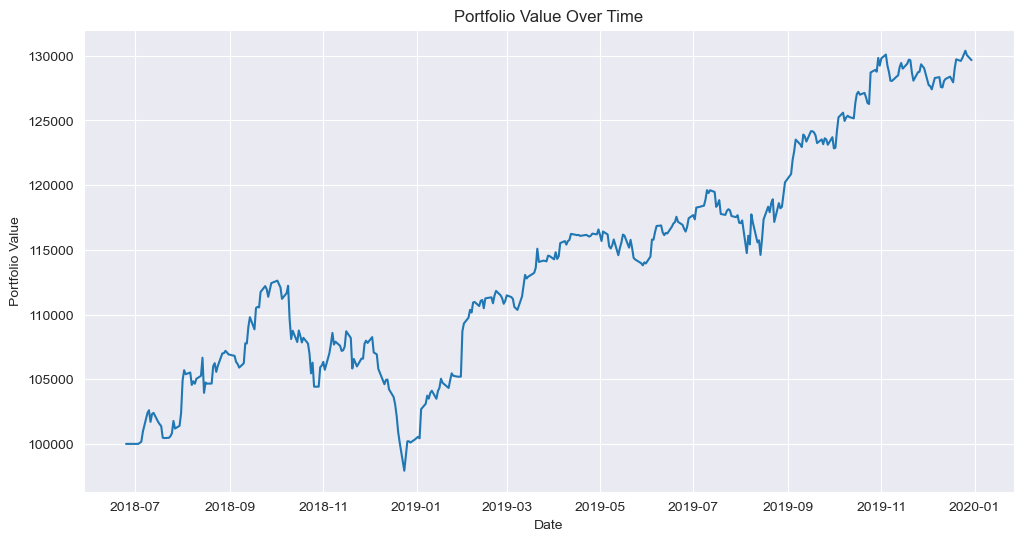

In [32]:
data['Tarih'] = pd.to_datetime(data['Tarih'])

# Tatil günlerini belirle
holidays = [
    '2018-12-25',  # Christmas
    '2019-01-01',  # New Year
    '2019-07-04',  # Independence Day
    '2019-04-19',  # Good Friday
    '2019-05-27',  # Memorial Day
    '2019-09-02',  # Labor Day
    '2019-11-28',  # Thanksgiving Day
]

# Belirli tarihler
specific_dates = [
    '2018-06-30 00:00:00',
    '2018-09-30 00:00:00',
    '2018-12-31 00:00:00',
    '2019-03-31 00:00:00',
    '2019-06-30 00:00:00',
    '2019-09-30 00:00:00',
    '2019-12-31 00:00:00'
]

# Tatil günlerini datetime formatına çevir
holidays = pd.to_datetime(holidays)

# İlk uygun işlem gününü bulma fonksiyonu
def find_next_trading_day(date):
    while date in holidays or date.weekday() >= 5:  # 5 ve 6, cumartesi ve pazar günlerini temsil eder
        date += datetime.timedelta(days=1)
    return date

# DataFrame'deki tarihleri güncelle
for original_date in specific_dates:
    original_date = pd.to_datetime(original_date)
    if original_date in data['Tarih'].values:
        next_trading_day = find_next_trading_day(original_date)
        data.loc[data['Tarih'] == original_date, 'Tarih'] = next_trading_day

# Backtrader için stratejiyi tanımla
class CustomStrategy(bt.Strategy):
    def __init__(self):
        self.open_orders = {}
        self.portfolio_value = []
        self.aapl_trades = []

    def next(self):
        #print("Next function is called")

        current_date = self.datas[0].datetime.date(0)
        current_date = find_next_trading_day(current_date)

        if current_date not in [d[0] for d in self.portfolio_value]:
            self.portfolio_value.append((current_date, self.broker.getvalue()))

        # Mevcut tarihteki işlemleri belirle
        today_data = data[data['Tarih'] == pd.Timestamp(current_date)]
        # Portföyü eşit şekilde dağıtmak için her pozisyon için kullanılacak miktarı belirle
        current_positions = [pos for pos in self.open_orders if self.open_orders[pos] == 'long']
        num_positions = len(today_data[today_data['Decile'] == 5])
        for pos in current_positions:
            if pos in today_data[today_data['Decile'] == 5]['OFTIC'].values:
                num_positions -= 1

        if num_positions > 0:
            cash_per_position = self.broker.getcash() / num_positions
            print("cpb= ", cash_per_position)
        print("num_position= ", num_positions)

        for _, row in today_data.iterrows():
            ticker = row['OFTIC']
            decile = row['Decile']
            d = self.getdatabyname(ticker)

            # Pozisyon aç
            if ticker in self.open_orders:
                if decile == 1 and self.open_orders[ticker] == 'long':
                    self.close(data=d)
                    self.sell(data=d, size=self.getposition(d).size)
                    self.open_orders[ticker] = 'short'
                    if ticker == 'EQR':
                        self.aapl_trades.append((current_date, 'CLOSE & SELL', self.getposition(d).size, d.close[0]))
                elif decile == 5 and self.open_orders[ticker] == 'short':
                    self.close(data=d)
                    self.buy(data=d, size=self.getposition(d).size)
                    self.open_orders[ticker] = 'long'
                    if ticker == 'EQR':
                        self.aapl_trades.append((current_date, 'CLOSE & BUY', self.getposition(d).size, d.close[0]))
                elif decile in [2, 3, 4]:
                    self.close(data=d)
                    del self.open_orders[ticker]
                    if ticker == 'EQR':
                        self.aapl_trades.append((current_date, 'CLOSE', self.getposition(d).size, d.close[0]))
            else:
                # Yeni pozisyon aç
                if decile == 1:
                    size = cash_per_position / d.close[0]
                    self.sell(data=d, size=size)
                    self.open_orders[ticker] = 'short'
                    if ticker == 'EQR':
                        self.aapl_trades.append((current_date, 'SELL', size, d.close[0]))
                elif decile == 5:
                    print(ticker)
                    size = cash_per_position / d.close[0]
                    self.buy(data=d, size=size)
                    self.open_orders[ticker] = 'long'
                    if ticker == 'EQR':
                        self.aapl_trades.append((current_date, 'BUY', size, d.close[0]))

# Backtrader için veriyi hazırlamak
class PandasData(bt.feeds.PandasData):
    lines = ('decile',)
    params = (('decile', -1),)

# Veriyi Backtrader'a uygun hale getir ve ekle
start_date = '2018-06-25'
end_date = '2019-12-31'

cerebro = bt.Cerebro()
cerebro.addstrategy(CustomStrategy)

# Veriyi Backtrader'a uygun hale getir ve ekle
tickers = data['OFTIC'].unique()
price_data = {}
for ticker in tickers:
    ticker_data = yf.download(ticker, start=start_date, end=end_date)
    price_data[ticker] = ticker_data['Adj Close']

    # Sadece 'Adj Close' sütununu kullanarak yeniden adlandır
    ticker_data = ticker_data[['Adj Close']].rename(columns={'Adj Close': 'close'})
    ticker_data['open'] = ticker_data['close']
    ticker_data['high'] = ticker_data['close']
    ticker_data['low'] = ticker_data['close']
    ticker_data['volume'] = 0
    ticker_data['openinterest'] = 0

    ticker_decile = data[data['OFTIC'] == ticker][['Tarih', 'Decile']].set_index('Tarih')
    ticker_data = ticker_data.join(ticker_decile)
    ticker_data.index.name = 'datetime'

    feed = PandasData(dataname=ticker_data)
    cerebro.adddata(feed, name=ticker)

# Başlangıç bakiyesini ayarla
cerebro.broker.set_cash(100000.0)

# Komisyonu ayarla
cerebro.broker.setcommission(commission=0.000)

# Başlangıç koşullarını yazdır
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Backtest'i çalıştır
results = cerebro.run()

# Sonuçları yazdır
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# EQR için yapılan işlemleri yazdır
strategy = results[0]
for trade in strategy.aapl_trades:
    print(trade)

# Portföy değerini çizgi grafik olarak göster
portfolio_values = strategy.portfolio_value
dates, values = zip(*portfolio_values)

plt.figure(figsize=(12, 6))
plt.plot(dates, values)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


In [30]:
data['Tarih'].unique()


<DatetimeArray>
['2018-07-02 00:00:00', '2018-10-01 00:00:00', '2018-12-31 00:00:00',
 '2019-04-01 00:00:00', '2019-07-01 00:00:00', '2019-09-30 00:00:00',
 '2019-12-31 00:00:00']
Length: 7, dtype: datetime64[ns]

In [34]:
import pandas as pd
import numpy as np

# Başlangıç ve bitiş tarihleri
start_date = '2018-06-25'
end_date = '2019-12-31'

# Tatil günlerini belirle
holidays = [
    '2018-12-25',  # Christmas
    '2019-01-01',  # New Year
    '2019-07-04',  # Independence Day
    '2019-04-19',  # Good Friday
    '2019-05-27',  # Memorial Day
    '2019-09-02',  # Labor Day
    '2019-11-28',  # Thanksgiving Day
]
holidays = pd.to_datetime(holidays)

# Tüm günleri al
all_days = pd.date_range(start=start_date, end=end_date, freq='B')

# Tatil günlerini çıkar
trading_days = all_days[~all_days.isin(holidays)]

# İşlem günlerinin sayısını yazdır
print(len(trading_days))


390


In [44]:
portfolio_std_dev = np.std(portfolio_returns)

annualized_std_dev = portfolio_std_dev * np.sqrt(252)
annualized_std_dev

0.1053173418117605

In [98]:
sp500 = yf.download('^GSPC', start='2018-12-31', end='2019-09-30')
sp500['Return'] = sp500['Adj Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


In [35]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm

# Tarih aralığı
start_date = '2018-06-25'
end_date = '2019-12-31'

# S&P 500 endeks verilerini al
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']

# Risksiz faiz oranı (günlük %2 yıllık oran)
risk_free_rate = 0.02 / 252

# Portföy değeri verisi (Örneğin, daha önce hesapladığımız)
portfolio_values = strategy.portfolio_value
dates, values = zip(*portfolio_values)
portfolio_df = pd.DataFrame({'Date': dates, 'Portfolio Value': values}).set_index('Date')

# Getirileri hesapla
portfolio_returns = portfolio_df['Portfolio Value'].pct_change().dropna()
sp500_returns = sp500.pct_change().dropna()

# Risksiz getiriyi hesapla
risk_free_returns = np.full(len(portfolio_returns), risk_free_rate)

# Aşırı getirileri hesapla
excess_portfolio_returns = portfolio_returns - risk_free_returns
excess_sp500_returns = sp500_returns - risk_free_returns

# Regresyon modeli kur
X = sm.add_constant(excess_sp500_returns)
model = sm.OLS(excess_portfolio_returns, X).fit()
alpha = model.params[0]
beta = model.params[1]

# Sonuçları yazdır
print(f'Alpha: {alpha}')
print(f'Beta: {beta}')


[*********************100%%**********************]  1 of 1 completed

Alpha: 0.00041889654797201676
Beta: 0.5035771696175575



/var/folders/8y/1xpfmccx4pdc37lkv_91bn840000gn/T/ipykernel_99109/185227017.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]
/var/folders/8y/1xpfmccx4pdc37lkv_91bn840000gn/T/ipykernel_99109/185227017.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


In [45]:
print(portfolio_returns.sum())

print(sp500_returns.sum())

0.2682583446352106
0.1859652992321399


In [112]:
sp500
sp500_returns = sp500.loc[sp500.index.isin(dates), 'Return']
sp500_returns

/var/folders/8y/1xpfmccx4pdc37lkv_91bn840000gn/T/ipykernel_82275/2354017360.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  sp500_returns = sp500.loc[sp500.index.isin(dates), 'Return']


Date
2018-12-31         NaN
2019-01-02    0.001268
2019-01-03   -0.024757
2019-01-04    0.034336
2019-01-07    0.007010
                ...   
2019-09-23   -0.000097
2019-09-24   -0.008416
2019-09-25    0.006159
2019-09-26   -0.002429
2019-09-27   -0.005316
Name: Return, Length: 188, dtype: float64

In [116]:
# Portföy günlük değerlerini DataFrame olarak oluşturma
portfolio_df = pd.DataFrame(data={'Date': dates, 'Portfolio Value': values})
portfolio_df.set_index('Date', inplace=True)
portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change().dropna()

# Portföyün günlük getirilerinin standart sapmasını hesaplama
portfolio_std_dev = portfolio_returns.std()
portfolio_std_dev

0.006052984683539323

Annualized Sharpe Ratio: nan


/var/folders/8y/1xpfmccx4pdc37lkv_91bn840000gn/T/ipykernel_82275/172482197.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  sp500_returns = sp500.loc[sp500.index.isin(dates), 'Return']


In [32]:
decile_5 = data[data['Decile']==5]
decile_5[decile_5['Tarih']== '2018-12-31']

,Tarih,OFTIC,Predicted EPS,Actual EPS,Predicted EPS Next,Difference,Decile
149,2018-12-31,BG,1.522506,0.080,1.158462,13.480773,5
205,2018-12-31,BX,1.145028,0.050,1.071429,20.428575,5
569,2018-12-31,EQR,4.271126,0.310,4.795559,14.469544,5
646,2018-12-31,FCX,1.061235,0.110,1.036737,8.424886,5
1269,2018-12-31,NVDA,0.871978,0.025,0.663809,25.552364,5


In [22]:
decile_5[decile_5['Tarih']== '2018-10-01']


NameError: name 'decile_5' is not defined

In [32]:
data[data['OFTIC']=='EQR']

,Tarih,OFTIC,Predicted EPS,Actual EPS,Predicted EPS Next,Difference,Decile
567,2018-07-02,EQR,3.532840,0.31,3.305173,9.661849,5
568,2018-10-01,EQR,3.305173,0.60,4.271126,6.118543,5
569,2018-12-31,EQR,4.271126,0.31,4.795559,14.469544,5
570,2019-04-01,EQR,4.795559,0.28,4.933460,16.619498,5
571,2019-07-01,EQR,4.933460,0.83,5.076401,5.116145,2
572,2019-09-30,EQR,5.076401,0.71,6.622829,8.327928,5


In [12]:
data[data['OFTIC']=='AAPL']

,Tarih,OFTIC,Predicted EPS,Actual EPS,Predicted EPS Next,Difference
0,2018-06-30,AAPL,0.641207,0.5850,0.628007,0.073517
1,2018-09-30,AAPL,0.628007,0.7275,0.985615,0.354798
2,2018-12-31,AAPL,0.985615,1.0450,0.839935,-0.196234
3,2019-03-31,AAPL,0.839935,0.6150,0.706372,0.148573
4,2019-06-30,AAPL,0.706372,0.5450,0.695098,0.275408
5,2019-09-30,AAPL,0.695098,0.7575,1.022004,0.349180


In [93]:
cerebro.broker.setcash(1000000.0)

cerebro.addsizer(bt.sizers.PercentSizer, percents = 10)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(btanalyzers.Returns,     _name = "returns")
cerebro.addanalyzer(btanalyzers.Transactions, _name = "trans")

back = cerebro.run()

cerebro.broker.getvalue()
back[0].analyzers.returns.get_analysis()['rnorm100']
back[0].analyzers.sharpe.get_analysis()
back[0].analyzers.trans.get_analysis()

OrderedDict([(datetime.datetime(2018, 7, 3, 0, 0),
              [[-41.75297904982605,
                89.69161987304688,
                2,
                'ALB',
                3744.8923255042882],
               [-42.28300341164403,
                84.697998046875,
                4,
                'AMZN',
                3581.285740375435],
               [92.02139706978828,
                40.34267807006836,
                8,
                'APA',
                -3712.3895975444],
               [34.4366298614886,
                106.02525329589844,
                11,
                'ARE',
                -3651.1524037214285],
               [25.857988015046665,
                140.43081665039062,
                12,
                'AVB',
                -3631.2583738890166],
               [-39.95846046831877,
                90.36725616455078,
                14,
                'AVY',
                3610.936433081638],
               [46.690600700610645,
              

In [44]:
results = cerebro.run()

portfolio_values = results[0].portfolio_value
dates, values = zip(*portfolio_values)

plt.figure(figsize=(12, 6))
plt.plot(dates, values)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (TL)')
plt.grid(True)
plt.show()

AttributeError: 'Lines_LineSeries_LineIterator_DataAccessor_Strateg' object has no attribute 'portfolio_value'

In [14]:
decile_1_companies

,Tarih,OFTIC,Predicted EPS,Actual EPS,Predicted EPS Next,Difference,Decile
2,2018-12-31,AAPL,0.985615,1.0450,0.6150,-0.411483,1
3,2019-03-31,AAPL,0.839935,0.6150,0.5450,-0.113821,1
31,2019-03-31,AMZN,0.210970,0.3545,0.2610,-0.263752,1
32,2019-06-30,AMZN,0.234852,0.2610,0.2115,-0.189655,1
37,2018-12-31,ANSS,1.250290,2.1300,1.2900,-0.394366,1
...,...,...,...,...,...,...,...
1905,2018-09-30,XEL,0.856675,0.9600,0.4200,-0.562500,1
1907,2019-03-31,XEL,0.741933,0.6100,0.4600,-0.245902,1
1909,2019-09-30,XEL,0.881074,1.0100,0.5600,-0.445545,1
1913,2018-12-31,XOM,1.238910,1.4100,0.5500,-0.609929,1


In [34]:
import pandas as pd
import yfinance as yf

# Şirketlerin tickers listesi
companies = ['CHTR', 'UDR', 'MOH', 'EOG', 'OXY', 'APA', 'EQR', 'SBAC', 'NRG', 'POOL', 'MLM',
             'MOS', 'BG', 'NVDA', 'CF', 'BX']

# Tarih aralığını belirle
start_date = '2018-06-30'
end_date = '2019-12-31'

# İlgili tarihler listesi
relevant_dates = ['2018-07-02', '2018-10-01', '2018-12-31', '2019-04-01', '2019-07-01', '2019-09-30', '2019-12-30']

# Hisse fiyatlarını yfinance'dan çekmek
price_data = {}
for ticker in companies:
    ticker_data = yf.download(ticker, start=start_date, end=end_date)
    price_data[ticker] = ticker_data['Adj Close']

# Hisse fiyatlarını bir DataFrame'de birleştir
price_df = pd.DataFrame(price_data)
price_df.index.name = 'Date'

# Sadece ilgili tarihlerdeki fiyatları seçmek
filtered_price_df = price_df.loc[relevant_dates]

# Her bir şirketin ilgili tarihlerdeki hisse fiyatlarını yazdırmak
for company in companies:
    print(f"\n{company} Hisse Fiyatları:")
    print(filtered_price_df[company])

# Çekilen veriyi göstermek
filtered_price_df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


CHTR Hisse Fiyatları:
Date
2018-07-02    293.910004
2018-10-01    321.589996
2018-12-31    284.970001
2019-04-01    346.220001
2019-07-01    397.739990
2019-09-30    412.119995
2019-12-30    483.079987
Name: CHTR, dtype: float64

UDR Hisse Fiyatları:
Date
2018-07-02    30.137941
2018-10-01    32.676056
2018-12-31    32.611752
2019-04-01    37.561405
2019-07-01    37.720528
2019-09-30    40.839935
2019-12-30    39.304504
Name: UDR, dtype: float64

MOH Hisse Fiyatları:
Date
2018-07-02     98.709999
2018-10-01    148.139999
2018-12-31    116.220001
2019-04-01    144.699997
2019-07-01    140.309998
2019-09-30    109.720001
2019-12-30    135.839996
Name: MOH, dtype: float64

EOG Hisse Fiyatları:
Date
2018-07-02     96.446419
2018-10-01    102.183121
2018-12-31     68.942879
2019-04-01     76.806236
2019-07-01     73.910233
2019-09-30     59.119980
2019-12-30     65.901863
Name: EOG, dtype: float64

OXY Hisse Fiyatları:
Date
2018-07-02    71.132103
2018-10-01    72.385803
2018-12-31    54.0

,CHTR,UDR,MOH,EOG,OXY,APA,EQR,SBAC,NRG,POOL,MLM,MOS,BG,NVDA,CF,BX
Date,,,,,,,,,,,,,,,,
2018-07-02,293.910004,30.137941,98.709999,96.446419,71.132103,39.373337,51.088562,156.658081,26.310112,144.030914,212.285889,25.651821,57.774220,5.998898,37.332935,25.935795
2018-10-01,321.589996,32.676056,148.139999,102.183121,72.385803,42.856743,53.583233,149.714081,31.990404,157.516418,176.391129,30.365585,56.785797,7.169710,47.432934,30.812201
2018-12-31,284.970001,32.611752,116.220001,68.942879,54.071541,23.401018,53.999111,153.994614,33.702419,140.631851,164.843018,27.003580,45.267948,3.311148,37.890160,24.169882
2019-04-01,346.220001,37.561405,144.699997,76.806236,59.891541,31.422506,61.806343,188.257965,35.584335,159.227890,196.160812,25.758614,45.161060,4.525679,36.676479,29.192883
2019-07-01,397.739990,37.720528,140.309998,73.910233,45.096577,26.417101,63.237354,214.017242,30.198143,182.082840,219.821442,23.432318,48.592953,4.130407,41.100487,38.769928
2019-09-30,412.119995,40.839935,109.720001,59.119980,40.998623,23.408701,72.114532,229.709869,33.781494,192.478912,264.738464,19.062389,49.327312,4.331056,43.737312,41.047256
2019-12-30,483.079987,39.304504,135.839996,65.901863,38.298504,23.579960,67.483025,227.526855,33.490528,205.667130,269.001068,19.608418,50.242100,5.784646,42.372993,47.502689


In [42]:
highest_5_companies[highest_5_companies['Tarih']=='2019-12-31']

,Tarih,OFTIC,Predicted EPS,Actual EPS,Difference
30,2019-12-31,NVDA,0.716511,0.065543,27.660433
31,2019-12-31,BX,1.159197,0.720000,22.183948
32,2019-12-31,EQR,6.622829,0.770000,20.363966
33,2019-12-31,BG,1.348949,1.270000,15.861860
34,2019-12-31,CHTR,11.629797,3.280000,8.015347
